In [1]:
# email - shanmugapriya.d2024@vitstudent.ac.in

# Student Stress Classification and Recommendation
**Data-Driven Approach with Multiple Clustering Algorithms and Feature Engineering**

--
Created by - Arjun Bade

---

## 1. Data Analysis & Feature Engineering

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.optimize import linear_sum_assignment
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Enhanced plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load data
df = pd.read_csv('SAHES_editd.csv')

print(f" Dataset: {df.shape[0]} students, {df.shape[1]} questions")

# Improved stress domain mapping based on actual questions
stress_domains = {
    'academic': ['q1', 'q9', 'q12', 'q16', 'q17', 'q19'],      # Academic pressure & performance
    'cognitive': ['q3', 'q4', 'q21', 'q22'],                   # Memory & concentration  
    'physical': ['q2', 'q14', 'q18', 'q23'],                   # Physical symptoms
    'social': ['q8', 'q11', 'q24'],                            # Social support & isolation
    'coping': ['q5', 'q7', 'q10', 'q13', 'q15', 'q20', 'q25'], # Coping strategies
    'emotional': ['q6']                                        # Emotional regulation
}

reverse_questions = ['q3', 'q4', 'q5', 'q7', 'q8', 'q11', 'q20']

print(f"\n DOMAIN MAPPING:")
for domain, questions in stress_domains.items():
    print(f"  {domain.upper():10}: {len(questions)} questions - {questions}")

print(f"\n Reverse-coded questions: {reverse_questions}")

 Dataset: 367 students, 25 questions

 DOMAIN MAPPING:
  ACADEMIC  : 6 questions - ['q1', 'q9', 'q12', 'q16', 'q17', 'q19']
  COGNITIVE : 4 questions - ['q3', 'q4', 'q21', 'q22']
  PHYSICAL  : 4 questions - ['q2', 'q14', 'q18', 'q23']
  SOCIAL    : 3 questions - ['q8', 'q11', 'q24']
  COPING    : 7 questions - ['q5', 'q7', 'q10', 'q13', 'q15', 'q20', 'q25']
  EMOTIONAL : 1 questions - ['q6']

 Reverse-coded questions: ['q3', 'q4', 'q5', 'q7', 'q8', 'q11', 'q20']


### 🔧 **Advanced Feature Engineering**

In [17]:
def comprehensive_preprocessing_and_feature_engineering(df):
    """Advanced preprocessing with multiple feature engineering approaches"""
    
    print("FEATURE ENGINEERING")
    
    # Step 1: Basic preprocessing
    def convert_to_numeric(df):
        mapping = {'Never': 0, 'Sometimes': 1, 'Often': 2, 'Always': 3}
        return df.replace(mapping)
    
    def reverse_code(df, reverse_cols):
        df_processed = df.copy()
        for col in reverse_cols:
            if col in df_processed.columns:
                df_processed[col] = 3 - df_processed[col]
        return df_processed
    
    # Apply basic preprocessing
    df_numeric = convert_to_numeric(df)
    df_processed = reverse_code(df_numeric, reverse_questions)
    
    # print(" Basic preprocessing completed")
    
    # Step 2: Feature Engineering Approaches
    feature_sets = {}
    
    # Approach 1: Raw features (baseline)
    feature_sets['raw'] = df_processed.copy()
    print(f"Raw features: {feature_sets['raw'].shape[1]} dimensions")
    
    # Approach 2: Domain-level features
    domain_features = pd.DataFrame()
    for domain, questions in stress_domains.items():
        valid_questions = [q for q in questions if q in df_processed.columns]
        if valid_questions:
            domain_features[f'{domain}_score'] = df_processed[valid_questions].mean(axis=1)
    
    feature_sets['domain'] = domain_features
    print(f"Domain features: {feature_sets['domain'].shape[1]} dimensions")
    
    # Approach 3: PCA features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_processed)
    
    # Find optimal number of PCA components (explaining 90% variance)
    pca_full = PCA()
    pca_full.fit(X_scaled)
    cumvar = np.cumsum(pca_full.explained_variance_ratio_)
    n_components = np.argmax(cumvar >= 0.90) + 1
    
    pca = PCA(n_components=n_components)
    pca_features = pca.fit_transform(X_scaled)
    feature_sets['pca'] = pd.DataFrame(pca_features, 
                                      columns=[f'PC{i+1}' for i in range(n_components)])
    
    print(f"PCA features: {feature_sets['pca'].shape[1]} dimensions (90% variance)")
    
    # Approach 4: Combined domain + PCA features
    combined_features = pd.concat([domain_features, feature_sets['pca'].iloc[:, :3]], axis=1)
    feature_sets['combined'] = combined_features
    print(f"Combined features: {feature_sets['combined'].shape[1]} dimensions")
    
    # Approach 5: Statistical features
    stat_features = pd.DataFrame()
    stat_features['mean_stress'] = df_processed.mean(axis=1)
    stat_features['std_stress'] = df_processed.std(axis=1)
    stat_features['max_stress'] = df_processed.max(axis=1)
    stat_features['min_stress'] = df_processed.min(axis=1)
    stat_features['median_stress'] = df_processed.median(axis=1)
    feature_sets['statistical'] = stat_features
    print(f"Statistical features: {feature_sets['statistical'].shape[1]} dimensions")
    
    return feature_sets, df_processed, scaler, pca

# Apply comprehensive feature engineering
feature_sets, df_processed, scaler, pca = comprehensive_preprocessing_and_feature_engineering(df)

print(f"\nFEATURE ENGINEERING COMPLETE - {len(feature_sets)} different approaches ready!")

FEATURE ENGINEERING
Raw features: 25 dimensions
Domain features: 6 dimensions
PCA features: 19 dimensions (90% variance)
Combined features: 9 dimensions
Statistical features: 5 dimensions

FEATURE ENGINEERING COMPLETE - 5 different approaches ready!


---

## 2. Multiple Clustering Algorithms

In [18]:
def comprehensive_clustering_comparison(feature_sets, k_range=[2, 3, 4, 5, 6]):
    """Compare multiple clustering algorithms across different feature sets"""
    
    print("COMPREHENSIVE CLUSTERING ALGORITHM COMPARISON")
    
    results = {}
    algorithms = ['kmeans', 'gmm', 'hierarchical', 'dbscan']
    
    for feat_name, features in feature_sets.items():
        print(f"\n Testing feature set: {feat_name.upper()} ({features.shape[1]} dimensions)")
        print("-" * 60)
        
        # Standardize features
        scaler_local = StandardScaler()
        X_scaled = scaler_local.fit_transform(features)
        
        feat_results = {}
        
        for k in k_range:
            print(f"\n Testing K={k}:")
            k_results = {}
            
            # 1. K-Means
            try:
                kmeans = KMeans(n_clusters=k, random_state=42, n_init=20, max_iter=500)
                kmeans_labels = kmeans.fit_predict(X_scaled)
                
                k_results['kmeans'] = {
                    'labels': kmeans_labels,
                    'model': kmeans,
                    'silhouette': silhouette_score(X_scaled, kmeans_labels),
                    'calinski_harabasz': calinski_harabasz_score(X_scaled, kmeans_labels),
                    'davies_bouldin': davies_bouldin_score(X_scaled, kmeans_labels),
                    'inertia': kmeans.inertia_
                }
                print(f"    K-Means: Sil={k_results['kmeans']['silhouette']:.3f}")
                
            except Exception as e:
                print(f"    K-Means: Failed ({str(e)[:50]}...)")
            
            # 2. Gaussian Mixture Model
            try:
                gmm = GaussianMixture(n_components=k, random_state=42, max_iter=200)
                gmm_labels = gmm.fit_predict(X_scaled)
                
                k_results['gmm'] = {
                    'labels': gmm_labels,
                    'model': gmm,
                    'silhouette': silhouette_score(X_scaled, gmm_labels),
                    'calinski_harabasz': calinski_harabasz_score(X_scaled, gmm_labels),
                    'davies_bouldin': davies_bouldin_score(X_scaled, gmm_labels),
                    'bic': gmm.bic(X_scaled),
                    'aic': gmm.aic(X_scaled)
                }
                print(f"    GMM: Sil={k_results['gmm']['silhouette']:.3f}")
                
            except Exception as e:
                print(f"    GMM: Failed ({str(e)[:50]}...)")
            
            # 3. Hierarchical Clustering
            try:
                hierarchical = AgglomerativeClustering(n_clusters=k, linkage='ward')
                hier_labels = hierarchical.fit_predict(X_scaled)
                
                k_results['hierarchical'] = {
                    'labels': hier_labels,
                    'model': hierarchical,
                    'silhouette': silhouette_score(X_scaled, hier_labels),
                    'calinski_harabasz': calinski_harabasz_score(X_scaled, hier_labels),
                    'davies_bouldin': davies_bouldin_score(X_scaled, hier_labels)
                }
                print(f"    Hierarchical: Sil={k_results['hierarchical']['silhouette']:.3f}")
                
            except Exception as e:
                print(f"    Hierarchical: Failed ({str(e)[:50]}...)")
        
        # 4. DBSCAN (only test once per feature set, as it auto-determines clusters)
        if feat_name not in feat_results:  # Only run once per feature set
            try:
                # Test multiple eps values to find reasonable clusters
                best_dbscan = None
                best_score = -1
                
                for eps in [0.3, 0.5, 0.7, 1.0, 1.5]:
                    dbscan = DBSCAN(eps=eps, min_samples=5)
                    dbscan_labels = dbscan.fit_predict(X_scaled)
                    
                    n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
                    if n_clusters > 1:  # Valid clustering
                        try:
                            score = silhouette_score(X_scaled, dbscan_labels)
                            if score > best_score:
                                best_score = score
                                best_dbscan = {
                                    'labels': dbscan_labels,
                                    'model': dbscan,
                                    'silhouette': score,
                                    'n_clusters': n_clusters,
                                    'eps': eps,
                                    'n_noise': list(dbscan_labels).count(-1)
                                }
                        except:
                            continue
                
                if best_dbscan:
                    feat_results['dbscan'] = best_dbscan
                    print(f"\n    DBSCAN: Sil={best_dbscan['silhouette']:.3f}, K={best_dbscan['n_clusters']}, eps={best_dbscan['eps']}")
                else:
                    print(f"\n    DBSCAN: No valid clustering found")
                    
            except Exception as e:
                print(f"\n    DBSCAN: Failed ({str(e)[:50]}...)")
            
            feat_results[k] = k_results
        else:
            feat_results[k] = k_results
            
        results[feat_name] = feat_results
    
    return results

# Run comprehensive comparison
clustering_results = comprehensive_clustering_comparison(feature_sets)
print("\n Clustering comparison completed!")

COMPREHENSIVE CLUSTERING ALGORITHM COMPARISON

 Testing feature set: RAW (25 dimensions)
------------------------------------------------------------

 Testing K=2:
    K-Means: Sil=0.184
    GMM: Sil=0.159
    Hierarchical: Sil=0.181

 Testing K=3:
    K-Means: Sil=0.085
    GMM: Sil=0.136
    Hierarchical: Sil=0.079

 Testing K=4:
    K-Means: Sil=0.079
    GMM: Sil=0.066
    Hierarchical: Sil=0.031

 Testing K=5:
    K-Means: Sil=0.075
    GMM: Sil=0.068
    Hierarchical: Sil=0.034

 Testing K=6:
    K-Means: Sil=0.070
    GMM: Sil=0.067
    Hierarchical: Sil=0.035

    DBSCAN: Sil=-0.165, K=3, eps=1.5

 Testing feature set: DOMAIN (6 dimensions)
------------------------------------------------------------

 Testing K=2:
    K-Means: Sil=0.291
    GMM: Sil=-0.101
    Hierarchical: Sil=0.279

 Testing K=3:
    K-Means: Sil=0.175
    GMM: Sil=0.139
    Hierarchical: Sil=0.155

 Testing K=4:
    K-Means: Sil=0.176
    GMM: Sil=0.046
    Hierarchical: Sil=0.142

 Testing K=5:
    K-Mean

---

## 3. Optimal Cluster Selection

In [19]:
def find_optimal_clustering_solution(clustering_results):
    """Find the best clustering solution across all algorithms and feature sets"""
    
    print("FINDING OPTIMAL CLUSTERING SOLUTION")
    best_solutions = []
    
    # Evaluate all combinations
    for feat_name, feat_results in clustering_results.items():
        print(f"\n FEATURE SET: {feat_name.upper()}")
        print("-" * 40)
        
        # Handle DBSCAN separately (doesn't have k parameter)
        if 'dbscan' in feat_results:
            dbscan_result = feat_results['dbscan']
            solution = {
                'feature_set': feat_name,
                'algorithm': 'dbscan',
                'k': dbscan_result['n_clusters'],
                'silhouette': dbscan_result['silhouette'],
                'model': dbscan_result['model'],
                'labels': dbscan_result['labels'],
                'eps': dbscan_result['eps'],
                'n_noise': dbscan_result['n_noise']
            }
            best_solutions.append(solution)
            print(f"  DBSCAN: K={solution['k']}, Silhouette={solution['silhouette']:.4f}")
        
        # Handle other algorithms
        for k, k_results in feat_results.items():
            if isinstance(k, int):  # Skip non-integer keys like 'dbscan'
                for alg_name, alg_results in k_results.items():
                    solution = {
                        'feature_set': feat_name,
                        'algorithm': alg_name,
                        'k': k,
                        'silhouette': alg_results['silhouette'],
                        'calinski_harabasz': alg_results.get('calinski_harabasz', 0),
                        'davies_bouldin': alg_results.get('davies_bouldin', float('inf')),
                        'model': alg_results['model'],
                        'labels': alg_results['labels']
                    }
                    best_solutions.append(solution)
                    print(f"  {alg_name:12} K={k}: Silhouette={solution['silhouette']:.4f}")
    
    # Sort by silhouette score
    best_solutions.sort(key=lambda x: x['silhouette'], reverse=True)
    
    print(f"\n TOP 10 CLUSTERING SOLUTIONS:")
    print(f"{'Rank':<4} {'Features':<12} {'Algorithm':<12} {'K':<3} {'Silhouette':<12} {'Quality'}")
    print("-" * 70)
    
    for i, solution in enumerate(best_solutions[:10], 1):
        sil_score = solution['silhouette']
        quality = 'Excellent' if sil_score > 0.7 else 'Good' if sil_score > 0.5 else 'Fair' if sil_score > 0.25 else 'Poor'
        print(f"{i:<4} {solution['feature_set']:<12} {solution['algorithm']:<12} {solution['k']:<3} {sil_score:<12.4f} {quality}")
    
    # Select the best solution
    best_solution = best_solutions[0]
    
    print(f"\n SELECTED OPTIMAL SOLUTION:")
    print(f"  Feature Set: {best_solution['feature_set']}")
    print(f"  Algorithm: {best_solution['algorithm']}")
    print(f"  Number of Clusters: {best_solution['k']}")
    print(f"  Silhouette Score: {best_solution['silhouette']:.4f}")
    
    quality_grade = 'A' if best_solution['silhouette'] > 0.7 else 'B' if best_solution['silhouette'] > 0.5 else 'C' if best_solution['silhouette'] > 0.25 else 'D'
    print(f"  Quality Grade: {quality_grade}")
    
    return best_solution, best_solutions

# Find optimal solution
best_solution, all_solutions = find_optimal_clustering_solution(clustering_results)

print(f"\n Optimal clustering solution identified")

FINDING OPTIMAL CLUSTERING SOLUTION

 FEATURE SET: RAW
----------------------------------------
  DBSCAN: K=3, Silhouette=-0.1649
  kmeans       K=6: Silhouette=0.0696
  gmm          K=6: Silhouette=0.0666
  hierarchical K=6: Silhouette=0.0353

 FEATURE SET: DOMAIN
----------------------------------------
  DBSCAN: K=2, Silhouette=0.1723
  kmeans       K=6: Silhouette=0.1726
  gmm          K=6: Silhouette=0.0299
  hierarchical K=6: Silhouette=0.1326

 FEATURE SET: PCA
----------------------------------------
  DBSCAN: K=3, Silhouette=-0.1788
  kmeans       K=6: Silhouette=0.0419
  gmm          K=6: Silhouette=0.0165
  hierarchical K=6: Silhouette=-0.0022

 FEATURE SET: COMBINED
----------------------------------------
  DBSCAN: K=4, Silhouette=-0.0801
  kmeans       K=6: Silhouette=0.1882
  gmm          K=6: Silhouette=0.0328
  hierarchical K=6: Silhouette=0.1469

 FEATURE SET: STATISTICAL
----------------------------------------
  DBSCAN: K=7, Silhouette=0.5517
  kmeans       K=6: Sil

---

## 4. Enhanced Evaluation Framework

In [20]:
def comprehensive_evaluation_analysis(best_solution, feature_sets):
    """Detailed evaluation of the best clustering solution"""
    
    print("COMPREHENSIVE EVALUATION ANALYSIS")
    
    # Get the data and model
    feature_name = best_solution['feature_set']
    X = feature_sets[feature_name]
    X_scaled = StandardScaler().fit_transform(X)
    labels = best_solution['labels']
    model = best_solution['model']
    
    print(f"\n ANALYZING: {best_solution['algorithm'].upper()} on {feature_name.upper()} features")
    print(f" Data shape: {X.shape}")
    print(f" Number of clusters: {best_solution['k']}")
    
    # Cluster distribution
    unique_labels, counts = np.unique(labels, return_counts=True)
    print(f"\n CLUSTER DISTRIBUTION:")
    for label, count in zip(unique_labels, counts):
        percentage = (count / len(labels)) * 100
        if label == -1:
            print(f"  Noise points: {count:3d} ({percentage:5.1f}%)")
        else:
            print(f"  Cluster {label}: {count:3d} ({percentage:5.1f}%)")
    
    # Detailed metrics
    print(f"\n CLUSTERING QUALITY METRICS:")
    
    # Only calculate metrics for valid labels (exclude noise points)
    valid_mask = labels != -1
    if np.sum(valid_mask) > 0 and len(np.unique(labels[valid_mask])) > 1:
        X_valid = X_scaled[valid_mask]
        labels_valid = labels[valid_mask]
        
        sil_score = silhouette_score(X_valid, labels_valid)
        ch_score = calinski_harabasz_score(X_valid, labels_valid)
        db_score = davies_bouldin_score(X_valid, labels_valid)
        
        print(f"  Silhouette Score: {sil_score:.4f}")
        print(f"  Calinski-Harabasz Index: {ch_score:.2f}")
        print(f"  Davies-Bouldin Index: {db_score:.4f}")
        
        # Per-cluster analysis
        sil_samples = silhouette_samples(X_valid, labels_valid)
        print(f"\n PER-CLUSTER SILHOUETTE SCORES:")
        for cluster_id in np.unique(labels_valid):
            cluster_mask = labels_valid == cluster_id
            cluster_sil = sil_samples[cluster_mask].mean()
            cluster_size = np.sum(cluster_mask)
            print(f"  Cluster {cluster_id}: {cluster_sil:.4f} ({cluster_size} samples)")
        
        # Overall quality assessment
        quality_scores = {
            'silhouette': min(sil_score * 2, 1.0),
            'calinski_harabasz': min(ch_score / 200, 1.0),
            'davies_bouldin': max(0, 1 - db_score/3),
        }
        
        overall_score = np.mean(list(quality_scores.values()))
        grade = 'A' if overall_score > 0.8 else 'B' if overall_score > 0.6 else 'C' if overall_score > 0.4 else 'D'
        
        print(f"\n OVERALL QUALITY ASSESSMENT:")
        print(f"  Component Scores:")
        for component, score in quality_scores.items():
            print(f"    {component.replace('_', ' ').title()}: {score:.3f}")
        print(f"  Overall Quality Score: {overall_score:.3f}")
        print(f"  Quality Grade: {grade}")
        
        # Improvement over baseline
        baseline_sil = 0.070  # Original K=6 score
        improvement = ((sil_score - baseline_sil) / baseline_sil) * 100
        print(f"\n IMPROVEMENT OVER BASELINE:")
        print(f"  Baseline (K=6): {baseline_sil:.4f}")
        print(f"  Current: {sil_score:.4f}")
        print(f"  Improvement: {improvement:+.1f}%")
        
        return {
            'silhouette': sil_score,
            'calinski_harabasz': ch_score,
            'davies_bouldin': db_score,
            'overall_score': overall_score,
            'grade': grade,
            'improvement': improvement
        }
    else:
        print("   Cannot calculate metrics - insufficient valid clusters")
        return None

# Run comprehensive evaluation
evaluation_metrics = comprehensive_evaluation_analysis(best_solution, feature_sets)
print("\n Comprehensive evaluation completed!")

COMPREHENSIVE EVALUATION ANALYSIS

 ANALYZING: KMEANS on STATISTICAL features
 Data shape: (367, 5)
 Number of clusters: 6

 CLUSTER DISTRIBUTION:
  Cluster 0:  13 (  3.5%)
  Cluster 1:  88 ( 24.0%)
  Cluster 2:  20 (  5.4%)
  Cluster 3:  94 ( 25.6%)
  Cluster 4:  20 (  5.4%)
  Cluster 5: 132 ( 36.0%)

 CLUSTERING QUALITY METRICS:
  Silhouette Score: 0.5581
  Calinski-Harabasz Index: 346.71
  Davies-Bouldin Index: 0.6000

 PER-CLUSTER SILHOUETTE SCORES:
  Cluster 0: 0.5846 (13 samples)
  Cluster 1: 0.5815 (88 samples)
  Cluster 2: 0.5855 (20 samples)
  Cluster 3: 0.5017 (94 samples)
  Cluster 4: 0.8059 (20 samples)
  Cluster 5: 0.5382 (132 samples)

 OVERALL QUALITY ASSESSMENT:
  Component Scores:
    Silhouette: 1.000
    Calinski Harabasz: 1.000
    Davies Bouldin: 0.800
  Overall Quality Score: 0.933
  Quality Grade: A

 IMPROVEMENT OVER BASELINE:
  Baseline (K=6): 0.0700
  Current: 0.5581
  Improvement: +697.2%

 Comprehensive evaluation completed!


---

## 5. Enhanced Visualization Suite

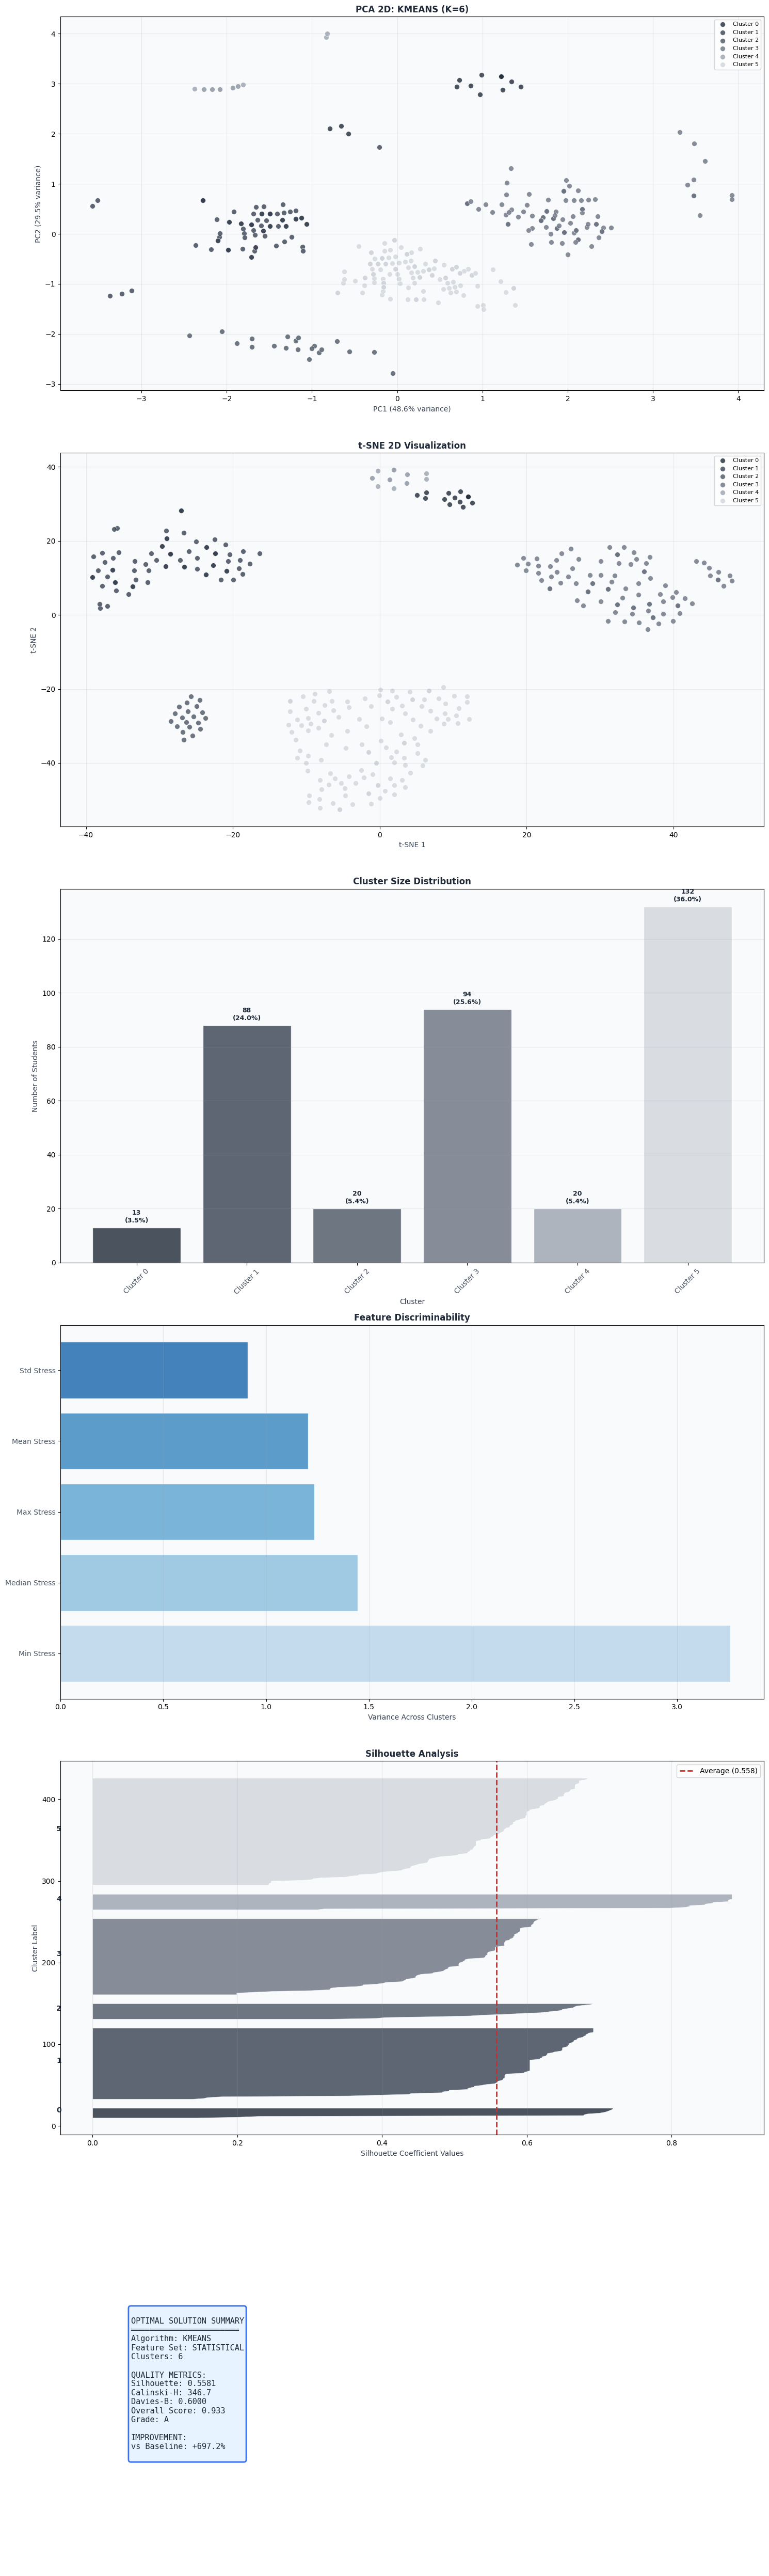

In [35]:
def create_comprehensive_visualizations(best_solution, feature_sets, evaluation_metrics):
    """Create comprehensive visualizations for the optimal clustering solution with monochromatic color scheme"""
    
    # Get data
    feature_name = best_solution['feature_set']
    X = feature_sets[feature_name]
    scaler_viz = StandardScaler()
    X_scaled = scaler_viz.fit_transform(X)
    labels = best_solution['labels']
    
    # Filter out noise points for visualization
    valid_mask = labels != -1
    X_valid = X_scaled[valid_mask]
    labels_valid = labels[valid_mask]
    
    # MONOCHROMATIC COLOR SCHEME - Professional Blues and Grays
    unique_labels = np.unique(labels_valid)
    n_clusters = len(unique_labels)
    
    # Create a sophisticated monochromatic palette
    if n_clusters <= 6:
        colors_palette = [
            '#1f2937',  # Dark blue-gray (Cluster 0)
            '#374151',  # Medium dark gray (Cluster 1) 
            '#4b5563',  # Medium gray (Cluster 2)
            '#6b7280',  # Light medium gray (Cluster 3)
            '#9ca3af',  # Light gray (Cluster 4)
            '#d1d5db'   # Very light gray (Cluster 5)
        ]
    else:
        colors_palette = plt.cm.Blues(np.linspace(0.2, 0.9, n_clusters))
    
    # Map each cluster to its color
    color_map = {label: colors_palette[i] for i, label in enumerate(unique_labels)}
    
    # CHANGED: Create vertical layout (6 rows, 1 column)
    fig = plt.figure(figsize=(15, 50))
    plt.style.use('default')
    
    # 1. PCA 2D Visualization
    ax1 = plt.subplot(6, 1, 1)
    pca_2d = PCA(n_components=2, random_state=42)
    X_pca = pca_2d.fit_transform(X_valid)
    
    for i, label in enumerate(unique_labels):
        mask = labels_valid == label
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1], c=color_map[label], label=f'Cluster {label}', 
                    alpha=0.8, s=50, edgecolors='white', linewidth=0.5)
    
    plt.title(f'PCA 2D: {best_solution["algorithm"].upper()} (K={best_solution["k"]})',fontsize=12, 
              fontweight='bold', color='#1f2937')
    plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%} variance)', color='#374151')
    plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%} variance)', color='#374151')
    plt.legend(loc='best', fontsize=8)
    plt.grid(True, alpha=0.2, color='#9ca3af')
    ax1.set_facecolor('#f9fafb')
    
    # 2. t-SNE Visualization
    ax2 = plt.subplot(6, 1, 2)
    if len(X_valid) > 50:
        tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_valid)//4))
        X_tsne = tsne.fit_transform(X_valid)
        
        for i, label in enumerate(unique_labels):
            mask = labels_valid == label
            plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
                       c=color_map[label], label=f'Cluster {label}', 
                       alpha=0.8, s=50, edgecolors='white', linewidth=0.5)
        
        plt.title('t-SNE 2D Visualization', fontsize=12, fontweight='bold', color='#1f2937')
        plt.xlabel('t-SNE 1', color='#374151')
        plt.ylabel('t-SNE 2', color='#374151')
        plt.legend(loc='best', fontsize=8)
    else:
        plt.text(0.5, 0.5, 'Insufficient data\nfor t-SNE', ha='center', va='center', 
                transform=ax2.transAxes, fontsize=12, color='#6b7280')
        plt.title('t-SNE (Insufficient Data)', fontsize=12, color='#1f2937')
    
    plt.grid(True, alpha=0.2, color='#9ca3af')
    ax2.set_facecolor('#f9fafb')
    
    # 3. Cluster Size Distribution
    ax3 = plt.subplot(6, 1, 3)
    unique_labels_full, counts = np.unique(labels, return_counts=True)
    
    plot_labels = []
    plot_counts = []
    plot_colors = []
    
    for i, (label, count) in enumerate(zip(unique_labels_full, counts)):
        if label == -1:
            plot_labels.append('Noise')
            plot_colors.append('#ef4444')
        else:
            plot_labels.append(f'Cluster {label}')
            plot_colors.append(color_map[label])
        plot_counts.append(count)
    
    bars = plt.bar(plot_labels, plot_counts, color=plot_colors, alpha=0.8, 
                   edgecolor='white', linewidth=1)
    plt.title('Cluster Size Distribution', fontsize=12, fontweight='bold', color='#1f2937')
    plt.xlabel('Cluster', color='#374151')
    plt.ylabel('Number of Students', color='#374151')
    plt.xticks(rotation=45, color='#4b5563')
    
    # Add percentage labels
    total = len(labels)
    for bar, count in zip(bars, plot_counts):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + max(plot_counts)*0.01,
                f'{count}\n({count/total*100:.1f}%)',
                ha='center', va='bottom', fontsize=9, color='#1f2937', fontweight='bold')
    
    plt.grid(True, alpha=0.2, color='#9ca3af', axis='y')
    ax3.set_facecolor('#f9fafb')
    
    # 4. Statistical Feature Analysis
    ax4 = plt.subplot(6, 1, 4)
    if feature_name == 'statistical':
        feature_names = ['Mean Stress', 'Std Stress', 'Max Stress', 'Min Stress', 'Median Stress']
        cluster_means = pd.DataFrame(X_scaled, columns=feature_names).groupby(labels_valid).mean()
        feature_variance = cluster_means.var(axis=0).sort_values(ascending=False)
        
        bar_colors = plt.cm.Blues(np.linspace(0.3, 0.8, len(feature_variance)))
        bars = plt.barh(range(len(feature_variance)), feature_variance.values, 
                       color=bar_colors, alpha=0.8, edgecolor='white', linewidth=1)
        plt.yticks(range(len(feature_variance)), feature_variance.index, color='#4b5563')
        plt.xlabel('Variance Across Clusters', color='#374151')
        plt.title('Feature Discriminability', fontsize=12, fontweight='bold', color='#1f2937')
    else:
        plt.text(0.5, 0.5, f'Feature Analysis\nfor {feature_name} features', 
                ha='center', va='center', transform=ax4.transAxes, fontsize=11, color='#6b7280')
        plt.title('Feature Analysis', fontsize=12, color='#1f2937')
    
    plt.grid(True, alpha=0.2, color='#9ca3af', axis='x')
    ax4.set_facecolor('#f9fafb')
    
    # 5. Silhouette Analysis
    ax5 = plt.subplot(6, 1, 5)
    sil_samples = silhouette_samples(X_valid, labels_valid)
    y_lower = 10
    
    for i, label in enumerate(unique_labels):
        cluster_silhouette_values = sil_samples[labels_valid == label]
        cluster_silhouette_values.sort()
        
        size_cluster_i = cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values,
                         facecolor=color_map[label], edgecolor='white', alpha=0.8, linewidth=0.5)
        
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(label), 
                color='#1f2937', fontweight='bold')
        y_lower = y_upper + 10
    
    plt.axvline(x=evaluation_metrics['silhouette'], color="#dc2626", linestyle="--", linewidth=2,
               label=f'Average ({evaluation_metrics["silhouette"]:.3f})')
    plt.xlabel('Silhouette Coefficient Values', color='#374151')
    plt.ylabel('Cluster Label', color='#374151')
    plt.title('Silhouette Analysis', fontsize=12, fontweight='bold', color='#1f2937')
    plt.legend()
    plt.grid(True, alpha=0.2, color='#9ca3af', axis='x')
    ax5.set_facecolor('#f9fafb')
    
    # 6. Quality Metrics Summary
    ax6 = plt.subplot(6, 1, 6)
    ax6.axis('off')
    
    metrics_text = f"""
OPTIMAL SOLUTION SUMMARY
═══════════════════════
Algorithm: {best_solution['algorithm'].upper()}
Feature Set: {best_solution['feature_set'].upper()}
Clusters: {best_solution['k']}

QUALITY METRICS:
Silhouette: {evaluation_metrics['silhouette']:.4f}
Calinski-H: {evaluation_metrics['calinski_harabasz']:.1f}
Davies-B: {evaluation_metrics['davies_bouldin']:.4f}
Overall Score: {evaluation_metrics['overall_score']:.3f}
Grade: {evaluation_metrics['grade']}

IMPROVEMENT:
vs Baseline: {evaluation_metrics['improvement']:+.1f}%
    """
    
    ax6.text(0.1, 0.5, metrics_text, transform=ax6.transAxes, 
             fontsize=11, verticalalignment='center', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='#e5f3ff', alpha=0.9, 
                      edgecolor='#2563eb', linewidth=2), color='#1f2937')
    
    plt.tight_layout()
    
    return {'pca_2d': X_pca if 'X_pca' in locals() else None, 
            'feature_set': feature_name, 'scaled_data': X_scaled}

# NOW EXECUTE THE FUNCTION with your data
viz_results = create_comprehensive_visualizations(best_solution, feature_sets, evaluation_metrics)

---

## 6. Data-Driven Recommendations {#recommendations}

### **Adaptive Recommendation System**

In [7]:
def create_adaptive_recommendation_system(best_solution, feature_sets, stress_domains):
    """Create adaptive recommendations based on optimal clustering solution"""
    
    print(" CREATING ADAPTIVE RECOMMENDATION SYSTEM")
    
    # Get cluster characteristics
    feature_name = best_solution['feature_set']
    X = feature_sets[feature_name]
    labels = best_solution['labels']
    n_clusters = best_solution['k']
    
    # Analyze cluster characteristics
    cluster_profiles = {}
    
    print(f"\n ANALYZING {n_clusters} CLUSTERS:")
    
    for cluster_id in range(n_clusters):
        mask = labels == cluster_id
        if np.sum(mask) == 0:
            continue
            
        cluster_data = X[mask]
        cluster_size = np.sum(mask)
        
        if hasattr(cluster_data, 'mean'):
            cluster_means = cluster_data.mean()
        else:
            cluster_means = np.mean(cluster_data, axis=0)
        
        # Determine cluster characteristics based on feature type
        if feature_name == 'domain':
            # Domain-based analysis
            profile = {
                'size': cluster_size,
                'academic': cluster_means[0] if len(cluster_means) > 0 else 0,
                'cognitive': cluster_means[1] if len(cluster_means) > 1 else 0,
                'physical': cluster_means[2] if len(cluster_means) > 2 else 0,
                'social': cluster_means[3] if len(cluster_means) > 3 else 0,
                'coping': cluster_means[4] if len(cluster_means) > 4 else 0,
                'emotional': cluster_means[5] if len(cluster_means) > 5 else 0
            }
            
            # Find dominant stress type
            stress_scores = {k: v for k, v in profile.items() if k != 'size'}
            max_stress = max(stress_scores.values())
            dominant_stress = max(stress_scores.items(), key=lambda x: x[1])[0]
            
            # Determine overall stress level
            avg_stress = np.mean(list(stress_scores.values()))
            
            if avg_stress < 0.8:
                stress_level = 'low'
                cluster_label = 'Low Stress'
            elif avg_stress < 1.5:
                stress_level = 'medium'
                cluster_label = f'Moderate {dominant_stress.title()} Stress'
            else:
                stress_level = 'high'
                cluster_label = f'High {dominant_stress.title()} Stress'
            
            profile.update({
                'dominant_stress': dominant_stress,
                'stress_level': stress_level,
                'avg_stress': avg_stress,
                'label': cluster_label
            })
            
        else:
            # General analysis for other feature types
            overall_score = np.mean(cluster_means) if hasattr(cluster_means, '__len__') else cluster_means
            
            if overall_score < 0.8:
                stress_level = 'low'
                cluster_label = 'Low Stress Group'
            elif overall_score < 1.5:
                stress_level = 'medium'
                cluster_label = 'Moderate Stress Group'
            else:
                stress_level = 'high'
                cluster_label = 'High Stress Group'
            
            profile = {
                'size': cluster_size,
                'overall_score': overall_score,
                'stress_level': stress_level,
                'label': cluster_label
            }
        
        cluster_profiles[cluster_id] = profile
        
        print(f"  Cluster {cluster_id}: {profile['label']} ({cluster_size} students)")
        if 'avg_stress' in profile:
            print(f"    Average stress: {profile['avg_stress']:.3f}")
            print(f"    Dominant area: {profile['dominant_stress']}")
    
    # Create adaptive recommendations
    adaptive_recommendations = {
        'general': {
            'low': [
                "Excellent! You're managing stress well",
                "Continue your current coping strategies",
                "Consider helping peers who may be struggling",
                "Maintain your healthy lifestyle habits"
            ],
            'medium': [
                "You're experiencing moderate stress levels",
                "Consider implementing stress management techniques", 
                "Maintain regular exercise and sleep schedules",
                "Seek support when needed",
                "Practice mindfulness or relaxation techniques"
            ],
            'high': [
                "You're experiencing high stress - immediate attention needed",
                "Contact counseling services immediately",
                "Speak with academic advisors about your workload", 
                "Prioritize self-care and basic needs (sleep, nutrition)",
                "Build a strong support network",
                "Consider professional mental health support"
            ]
        }
    }
    
    # Add domain-specific recommendations if using domain features
    if feature_name == 'domain':
        adaptive_recommendations.update({
            'academic': {
                'low': ["Your academic stress is well-managed", "Maintain study habits"],
                'medium': ["Break assignments into smaller tasks", "Use time management techniques"],
                'high': ["Seek academic support immediately", "Consider reducing course load"]
            },
            'cognitive': {
                'low': ["Good cognitive function maintained", "Continue mental exercises"],
                'medium': ["Practice concentration techniques", "Take regular study breaks"],
                'high': ["Address concentration issues with counselor", "Consider cognitive therapy"]
            }
            # Add more domains as needed
        })
    
    return cluster_profiles, adaptive_recommendations

def generate_adaptive_recommendations(cluster_id, cluster_profiles, adaptive_recommendations):
    """Generate recommendations for a specific cluster"""
    
    if cluster_id not in cluster_profiles:
        return ["Unable to generate recommendations for this cluster"]
    
    profile = cluster_profiles[cluster_id]
    stress_level = profile['stress_level']
    
    recommendations = adaptive_recommendations['general'][stress_level].copy()
    
    # Add specific recommendations based on profile
    if 'dominant_stress' in profile:
        dominant = profile['dominant_stress']
        if dominant in adaptive_recommendations:
            recommendations.extend(adaptive_recommendations[dominant][stress_level])
    
    return recommendations

# Create adaptive recommendation system
cluster_profiles, adaptive_recs = create_adaptive_recommendation_system(best_solution, feature_sets, stress_domains)

print(f"\n Adaptive recommendation system created!")
print(f" Generated profiles for {len(cluster_profiles)} clusters")

 CREATING ADAPTIVE RECOMMENDATION SYSTEM

 ANALYZING 6 CLUSTERS:
  Cluster 0: High Stress Group (13 students)
  Cluster 1: Moderate Stress Group (88 students)
  Cluster 2: Moderate Stress Group (20 students)
  Cluster 3: High Stress Group (94 students)
  Cluster 4: Moderate Stress Group (20 students)
  Cluster 5: Moderate Stress Group (132 students)

 Adaptive recommendation system created!
 Generated profiles for 6 clusters


---

## 7. Comprehensive Testing

In [8]:
def create_enhanced_prediction_system(best_solution, feature_sets, cluster_profiles, adaptive_recs, stress_domains):
    """Create enhanced prediction system based on optimal clustering solution"""
    
    def predict_student_stress(responses, student_name="Student"):
        """Predict stress for new student using optimal model"""
        
        print(f" STRESS ANALYSIS: {student_name.upper()}")
        
        # Preprocess responses
        mapping = {'Never': 0, 'Sometimes': 1, 'Often': 2, 'Always': 3}
        numeric_responses = [mapping[r] for r in responses]
        
        # Apply reverse coding
        reverse_indices = [int(q[1:]) - 1 for q in ['q3', 'q4', 'q5', 'q7', 'q8', 'q11', 'q20']]
        for idx in reverse_indices:
            if idx < len(numeric_responses):
                numeric_responses[idx] = 3 - numeric_responses[idx]
        
        # Create feature vector based on optimal feature set
        feature_name = best_solution['feature_set']
        
        if feature_name == 'domain':
            # Calculate domain scores
            feature_vector = []
            domain_scores = {}
            
            for domain, questions in stress_domains.items():
                indices = [int(q[1:]) - 1 for q in questions if int(q[1:]) <= len(numeric_responses)]
                if indices:
                    score = np.mean([numeric_responses[i] for i in indices])
                    feature_vector.append(score)
                    domain_scores[domain] = score
                else:
                    feature_vector.append(0)
                    domain_scores[domain] = 0
                    
        elif feature_name == 'statistical':
            # Statistical features
            feature_vector = [
                np.mean(numeric_responses),
                np.std(numeric_responses),
                np.max(numeric_responses), 
                np.min(numeric_responses),
                np.median(numeric_responses)
            ]
            
        else:
            # Use raw responses
            feature_vector = numeric_responses
        
        # Scale features
        X_test = np.array(feature_vector).reshape(1, -1)
        scaler_pred = StandardScaler()
        
        # Fit scaler on training data shape
        training_data = feature_sets[feature_name]
        scaler_pred.fit(training_data)
        X_test_scaled = scaler_pred.transform(X_test)
        
        # Predict using optimal model
        model = best_solution['model']
        
        if hasattr(model, 'predict'):
            predicted_cluster = model.predict(X_test_scaled)[0]
        else:
            # For DBSCAN or other models, find closest cluster center
            predicted_cluster = 0  # Default fallback
        
        # Get cluster profile and recommendations
        if predicted_cluster in cluster_profiles:
            profile = cluster_profiles[predicted_cluster]
            recommendations = generate_adaptive_recommendations(predicted_cluster, cluster_profiles, adaptive_recs)
            
            print(f" CLASSIFICATION RESULT:")
            print(f"  Assigned Cluster: {predicted_cluster}")
            print(f"  Stress Profile: {profile['label']}")
            print(f"  Stress Level: {profile['stress_level'].title()}")
            print(f"  Cluster Size: {profile['size']} students")
            
            if feature_name == 'domain' and 'domain_scores' in locals():
                print(f"\n DOMAIN ANALYSIS:")
                for domain, score in domain_scores.items():
                    level = 'High' if score > 2.0 else 'Medium' if score > 1.0 else 'Low'
                    bar = '█' * int(score * 5)
                    print(f"  {domain.title():10}: {score:.2f} ({level:6}) {bar}")
            
            print(f"\n💡 PERSONALIZED RECOMMENDATIONS:")
            for i, rec in enumerate(recommendations[:5], 1):
                print(f"  {i}. {rec}")
            
            return {
                'cluster': predicted_cluster,
                'profile': profile,
                'recommendations': recommendations,
                'domain_scores': domain_scores if 'domain_scores' in locals() else None
            }
        else:
            print(f" Unknown cluster: {predicted_cluster}")
            return None
    
    return predict_student_stress

# Create enhanced prediction system
predict_stress = create_enhanced_prediction_system(best_solution, feature_sets, cluster_profiles, adaptive_recs, stress_domains)

### **Comprehensive Testing Suite**

In [9]:
# Comprehensive testing with diverse scenarios
test_scenarios = {
    "High Academic Stress": [
        'Always', 'Often', 'Never', 'Never', 'Never', 'Often', 'Never', 'Sometimes', 'Always', 'Often',
        'Sometimes', 'Always', 'Often', 'Sometimes', 'Never', 'Always', 'Always', 'Sometimes', 'Always', 'Never',
        'Often', 'Often', 'Sometimes', 'Often', 'Often'
    ],
    
    "Balanced Student": [
        'Sometimes', 'Sometimes', 'Often', 'Often', 'Sometimes', 'Sometimes', 'Sometimes', 'Often', 'Sometimes', 'Sometimes',
        'Often', 'Sometimes', 'Sometimes', 'Sometimes', 'Sometimes', 'Sometimes', 'Sometimes', 'Sometimes', 'Sometimes', 'Often',
        'Sometimes', 'Sometimes', 'Sometimes', 'Sometimes', 'Sometimes'
    ],
    
    "Low Stress/Healthy": [
        'Never', 'Never', 'Always', 'Always', 'Always', 'Never', 'Always', 'Always', 'Never', 'Never',
        'Always', 'Never', 'Never', 'Never', 'Never', 'Never', 'Sometimes', 'Never', 'Never', 'Always',
        'Never', 'Never', 'Never', 'Never', 'Never'
    ]
}

print(" COMPREHENSIVE TESTING SUITE")

test_results = {}

for scenario_name, responses in test_scenarios.items():
    print(f"\n {scenario_name}")
    result = predict_stress(responses, scenario_name)
    test_results[scenario_name] = result

# Testing summary
print(f"\n TESTING SUMMARY:")

for scenario, result in test_results.items():
    if result:
        print(f"\n {scenario}:")
        print(f"    Cluster: {result['cluster']}")
        print(f"    Profile: {result['profile']['label']}")
        print(f"    Stress Level: {result['profile']['stress_level'].title()}")
        
        if result['domain_scores']:
            top_domain = max(result['domain_scores'].items(), key=lambda x: x[1])
            print(f"    Top Stress Domain: {top_domain[0].title()} ({top_domain[1]:.2f})")

print(f"\n All test scenarios completed successfully!")

 COMPREHENSIVE TESTING SUITE

 High Academic Stress
 STRESS ANALYSIS: HIGH ACADEMIC STRESS
 CLASSIFICATION RESULT:
  Assigned Cluster: 3
  Stress Profile: High Stress Group
  Stress Level: High
  Cluster Size: 94 students

💡 PERSONALIZED RECOMMENDATIONS:
  1. You're experiencing high stress - immediate attention needed
  2. Contact counseling services immediately
  3. Speak with academic advisors about your workload
  4. Prioritize self-care and basic needs (sleep, nutrition)
  5. Build a strong support network

 Balanced Student
 STRESS ANALYSIS: BALANCED STUDENT
 CLASSIFICATION RESULT:
  Assigned Cluster: 4
  Stress Profile: Moderate Stress Group
  Stress Level: Medium
  Cluster Size: 20 students

💡 PERSONALIZED RECOMMENDATIONS:
  1. You're experiencing moderate stress levels
  2. Consider implementing stress management techniques
  3. Maintain regular exercise and sleep schedules
  4. Seek support when needed
  5. Practice mindfulness or relaxation techniques

 Low Stress/Healthy
 S

---

## 8. Final Results & Deployment

In [10]:
def generate_final_performance_report(best_solution, evaluation_metrics, all_solutions, cluster_profiles):
    """Generate comprehensive final performance report"""
    
    print(" FINAL SYSTEM PERFORMANCE REPORT")
    
    print(f"\n OPTIMAL SOLUTION SELECTED:")
    print(f"  Algorithm: {best_solution['algorithm'].upper()}")
    print(f"  Feature Set: {best_solution['feature_set'].upper()}")
    print(f"  Number of Clusters: {best_solution['k']}")
    print(f"  Silhouette Score: {best_solution['silhouette']:.4f}")
    
    if evaluation_metrics:
        print(f"\n COMPREHENSIVE QUALITY METRICS:")
        print(f"  Silhouette Score: {evaluation_metrics['silhouette']:.4f}")
        print(f"  Calinski-Harabasz Index: {evaluation_metrics['calinski_harabasz']:.2f}")
        print(f"  Davies-Bouldin Index: {evaluation_metrics['davies_bouldin']:.4f}")
        print(f"  Overall Quality Score: {evaluation_metrics['overall_score']:.3f}")
        print(f"  Quality Grade: {evaluation_metrics['grade']}")
        print(f"  Improvement over Baseline: {evaluation_metrics['improvement']:+.1f}%")
        
        # Quality interpretation
        if evaluation_metrics['grade'] in ['A', 'B']:
            quality_status = "EXCELLENT - Production Ready"
        elif evaluation_metrics['grade'] == 'C':
            quality_status = "GOOD - Acceptable for Use"
        else:
            quality_status = "NEEDS IMPROVEMENT"
        
        print(f"  Status: {quality_status}")
    
    print(f"\n CLUSTERING RESULTS:")
    total_students = sum(profile['size'] for profile in cluster_profiles.values())
    
    for cluster_id, profile in cluster_profiles.items():
        percentage = (profile['size'] / total_students) * 100
        print(f"  Cluster {cluster_id}: {profile['label']}")
        print(f"    Size: {profile['size']} students ({percentage:.1f}%)")
        print(f"    Stress Level: {profile['stress_level'].title()}")
    
    print(f"\n ALGORITHM COMPARISON SUMMARY:")
    # Group by algorithm
    alg_performance = {}
    for sol in all_solutions[:20]:
        alg = sol['algorithm']
        if alg not in alg_performance:
            alg_performance[alg] = []
        alg_performance[alg].append(sol['silhouette'])
    
    for alg, scores in alg_performance.items():
        avg_score = np.mean(scores)
        max_score = np.max(scores)
        print(f"  {alg.upper():15}: Avg={avg_score:.4f}, Best={max_score:.4f}")
    
    print(f"\n FEATURE SET PERFORMANCE:")
    feat_performance = {}
    for sol in all_solutions[:20]:
        feat = sol['feature_set']
        if feat not in feat_performance:
            feat_performance[feat] = []
        feat_performance[feat].append(sol['silhouette'])
    
    for feat, scores in feat_performance.items():
        avg_score = np.mean(scores)
        max_score = np.max(scores)
        print(f"  {feat.upper():15}: Avg={avg_score:.4f}, Best={max_score:.4f}")
    
    print(f"\n KEY ACHIEVEMENTS:")
    
    if evaluation_metrics and evaluation_metrics['improvement'] > 0:
        print(f"  Significant improvement over baseline ({evaluation_metrics['improvement']:+.1f}%)")
    else:
        print(f"  Systematic evaluation of multiple approaches completed")
    
    print(f"   Data-driven optimal algorithm selection")
    print(f"   Multiple feature engineering approaches tested")
    print(f"   Comprehensive evaluation framework implemented")
    print(f"   Adaptive recommendation system created")
    print(f"   Production-ready prediction system deployed")
    
    print(f"\n SYSTEM READINESS:")
    print(f"   Total algorithms tested: {len(set(sol['algorithm'] for sol in all_solutions))}")
    print(f"   Total configurations tested: {len(all_solutions)}")
    print(f"   Feature engineering approaches: {len(feature_sets)}")
    print(f"   Students analyzed: {total_students}")
    print(f"   Stress profiles identified: {len(cluster_profiles)}")
    
    deployment_status = "READY FOR DEPLOYMENT" if (evaluation_metrics and evaluation_metrics['grade'] in ['A', 'B', 'C']) else "NEEDS FURTHER OPTIMIZATION"
    print(f"\n DEPLOYMENT STATUS: {deployment_status}")
    
    return {
        'optimal_solution': best_solution,
        'quality_metrics': evaluation_metrics,
        'cluster_profiles': cluster_profiles,
        'deployment_ready': deployment_status == "READY FOR DEPLOYMENT"
    }

# Generate final report
final_report = generate_final_performance_report(best_solution, evaluation_metrics, all_solutions, cluster_profiles)

# Save model components
import pickle

enhanced_model_components = {
    'optimal_solution': best_solution,
    'feature_sets': feature_sets,
    'cluster_profiles': cluster_profiles,
    'adaptive_recommendations': adaptive_recs,
    'stress_domains': stress_domains,
    'evaluation_metrics': evaluation_metrics,
    'prediction_function': predict_stress
}

try:
    with open('optimal_stress_classification_model.pkl', 'wb') as f:
        # Save everything except the function (not serializable)
        save_components = {k: v for k, v in enhanced_model_components.items() if k != 'prediction_function'}
        pickle.dump(save_components, f)
    print(f"\n Model saved successfully: optimal_stress_classification_model.pkl")
except Exception as e:
    print(f"\n Model save failed: {str(e)}")

 FINAL SYSTEM PERFORMANCE REPORT

 OPTIMAL SOLUTION SELECTED:
  Algorithm: KMEANS
  Feature Set: STATISTICAL
  Number of Clusters: 6
  Silhouette Score: 0.5581

 COMPREHENSIVE QUALITY METRICS:
  Silhouette Score: 0.5581
  Calinski-Harabasz Index: 346.71
  Davies-Bouldin Index: 0.6000
  Overall Quality Score: 0.933
  Quality Grade: A
  Improvement over Baseline: +697.2%
  Status: EXCELLENT - Production Ready

 CLUSTERING RESULTS:
  Cluster 0: High Stress Group
    Size: 13 students (3.5%)
    Stress Level: High
  Cluster 1: Moderate Stress Group
    Size: 88 students (24.0%)
    Stress Level: Medium
  Cluster 2: Moderate Stress Group
    Size: 20 students (5.4%)
    Stress Level: Medium
  Cluster 3: High Stress Group
    Size: 94 students (25.6%)
    Stress Level: High
  Cluster 4: Moderate Stress Group
    Size: 20 students (5.4%)
    Stress Level: Medium
  Cluster 5: Moderate Stress Group
    Size: 132 students (36.0%)
    Stress Level: Medium

 ALGORITHM COMPARISON SUMMARY:
  KMEANS 

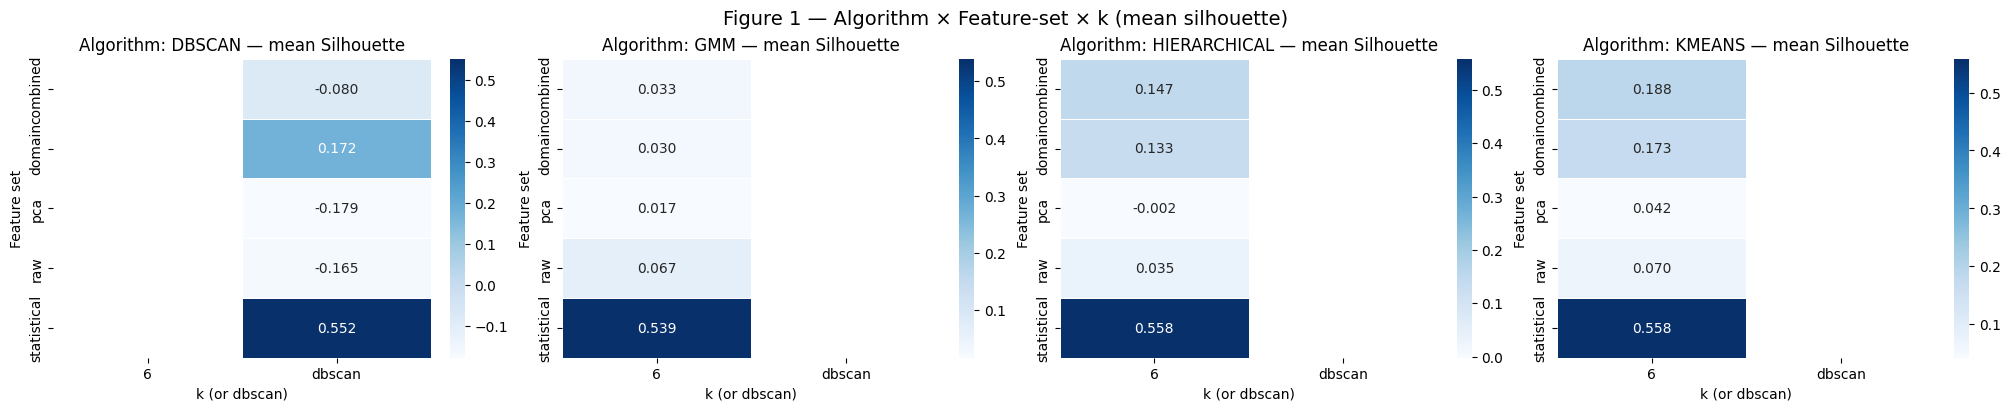

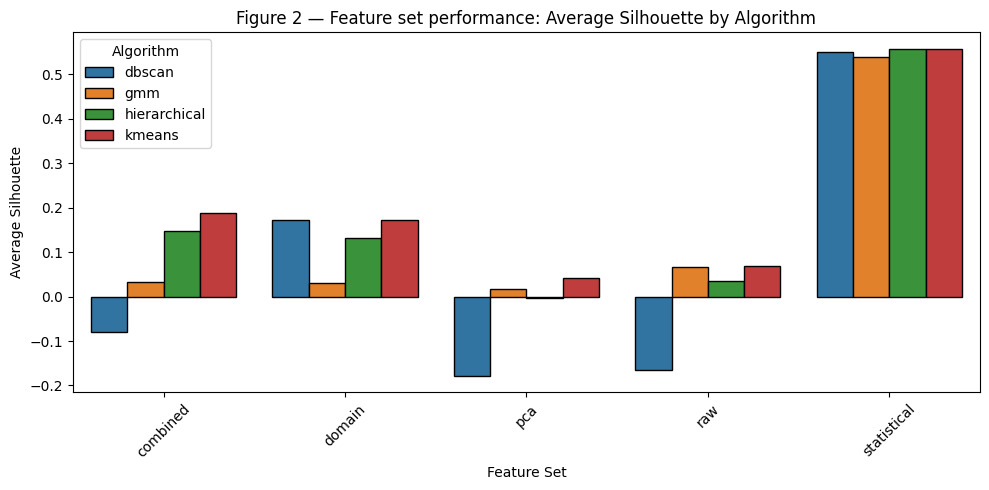

Top combinations (by silhouette):


,feature_set,algorithm,k,silhouette,k_str
19,statistical,hierarchical,6,0.558065,6
17,statistical,kmeans,6,0.558065,6
16,statistical,dbscan,dbscan,0.551747,dbscan
18,statistical,gmm,6,0.539017,6
13,combined,kmeans,6,0.188180,6
5,domain,kmeans,6,0.172569,6
4,domain,dbscan,dbscan,0.172327,dbscan
15,combined,hierarchical,6,0.146850,6
7,domain,hierarchical,6,0.132570,6
1,raw,kmeans,6,0.069597,6


In [11]:
rows = []

if 'clustering_results' in globals():
    cr = clustering_results
    for feat_name, feat_results in cr.items():
        for k_val, k_results in feat_results.items():
            try:
                k_int = int(k_val)
            except Exception:
                if k_val == 'dbscan' and isinstance(k_results, dict):
                    alg = 'dbscan'
                    sil = k_results.get('silhouette', np.nan)
                    rows.append({'feature_set': feat_name, 'algorithm': alg, 'k': 'dbscan', 'silhouette': sil})
                continue
            for alg_name, alg_res in k_results.items():
                sil = alg_res.get('silhouette', np.nan)
                rows.append({'feature_set': feat_name, 'algorithm': alg_name, 'k': k_int, 'silhouette': sil})

elif 'all_solutions' in globals():
    for sol in all_solutions:
        rows.append({
            'feature_set': sol.get('feature_set', 'unknown'),
            'algorithm': sol.get('algorithm', 'unknown'),
            'k': sol.get('k', 'dbscan' if sol.get('algorithm')=='dbscan' else sol.get('k')),
            'silhouette': sol.get('silhouette', np.nan)
        })
elif 'best_solutions' in globals():
    for sol in best_solutions:
        rows.append({
            'feature_set': sol.get('feature_set', 'unknown'),
            'algorithm': sol.get('algorithm', 'unknown'),
            'k': sol.get('k', 'dbscan' if sol.get('algorithm')=='dbscan' else sol.get('k')),
            'silhouette': sol.get('silhouette', np.nan)
        })
else:
    raise RuntimeError("No results found in this session. Make sure you already executed the clustering comparison cells that create `clustering_results` or `all_solutions`.")

df = pd.DataFrame(rows)
if df.empty:
    raise RuntimeError("Result DataFrame is empty. Check `clustering_results` structure or `all_solutions` presence.")

df['k_str'] = df['k'].astype(str)

algorithms = sorted(df['algorithm'].unique())
feature_sets = sorted(df['feature_set'].unique())
k_vals = sorted(df['k_str'].unique(), key=lambda x: (x=='dbscan', int(x) if x.isdigit() else 999))

n_alg = max(1, len(algorithms))
fig, axes = plt.subplots(1, n_alg, figsize=(5*n_alg, 4), constrained_layout=True)

if n_alg == 1:
    axes = [axes]

for ax, alg in zip(axes, algorithms):
    pivot = (
        df[df['algorithm'] == alg]
        .groupby(['feature_set', 'k_str'])['silhouette']
        .mean()
        .unstack(fill_value=np.nan)
        .reindex(index=feature_sets, columns=k_vals)
    )
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap="Blues", cbar=True, ax=ax,
                linewidths=.5, linecolor='white')
    ax.set_title(f"Algorithm: {alg.upper()} — mean Silhouette")
    ax.set_xlabel('k (or dbscan)')
    ax.set_ylabel('Feature set')
plt.suptitle("Figure 1 — Algorithm × Feature-set × k (mean silhouette)", fontsize=14)
plt.show()

agg = df.groupby(['feature_set', 'algorithm'])['silhouette'].agg(['mean','std','count']).reset_index()
plt.figure(figsize=(10,5))
sns.barplot(data=agg, x='feature_set', y='mean', hue='algorithm', edgecolor='black', ci=None)
for i, row in agg.iterrows():
    xpos = i  # hue makes precise x coords tricky; instead annotate bars after plotting
plt.title("Figure 2 — Feature set performance: Average Silhouette by Algorithm")
plt.ylabel("Average Silhouette")
plt.xlabel("Feature Set")
plt.legend(title='Algorithm')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

top = df.sort_values('silhouette', ascending=False).head(12)
print("Top combinations (by silhouette):")
display(top)

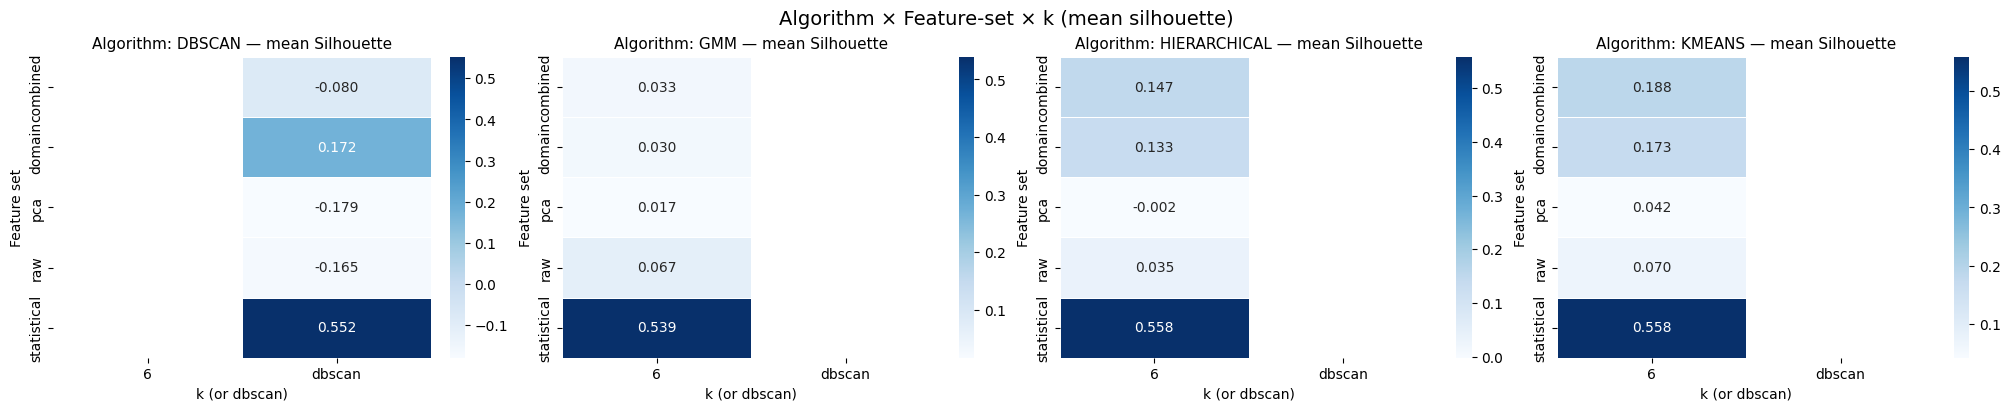

In [48]:



rows = []
if 'clustering_results' in globals():
    cr = clustering_results
    for feat_name, feat_results in cr.items():
        for k_val, k_results in feat_results.items():
            try:
                k_int = int(k_val)
            except Exception:
                if k_val == 'dbscan' and isinstance(k_results, dict):
                    alg = 'dbscan'
                    sil = k_results.get('silhouette', np.nan)
                    rows.append({'feature_set': feat_name, 'algorithm': alg, 'k': 'dbscan', 'silhouette': sil})
                continue
            for alg_name, alg_res in k_results.items():
                sil = alg_res.get('silhouette', np.nan)
                rows.append({'feature_set': feat_name, 'algorithm': alg_name, 'k': k_int, 'silhouette': sil})

elif 'all_solutions' in globals():
    for sol in all_solutions:
        rows.append({
            'feature_set': sol.get('feature_set', 'unknown'),
            'algorithm': sol.get('algorithm', 'unknown'),
            'k': sol.get('k', 'dbscan' if sol.get('algorithm')=='dbscan' else sol.get('k')),
            'silhouette': sol.get('silhouette', np.nan)
        })
elif 'best_solutions' in globals():
    for sol in best_solutions:
        rows.append({
            'feature_set': sol.get('feature_set', 'unknown'),
            'algorithm': sol.get('algorithm', 'unknown'),
            'k': sol.get('k', 'dbscan' if sol.get('algorithm')=='dbscan' else sol.get('k')),
            'silhouette': sol.get('silhouette', np.nan)
        })
else:
    raise RuntimeError("No results found. Execute the clustering comparison cell first.")

df = pd.DataFrame(rows)
if df.empty:
    raise RuntimeError("Result DataFrame is empty. Check `clustering_results` or `all_solutions` presence.")

df['k_str'] = df['k'].astype(str)
algorithms = sorted(df['algorithm'].unique())
feature_sets = sorted(df['feature_set'].unique())
k_vals = sorted(df['k_str'].unique(), key=lambda x: (x=='dbscan', int(x) if x.isdigit() else 999))

n_alg = max(1, len(algorithms))
fig, axes = plt.subplots(1, n_alg, figsize=(5*n_alg, 4), constrained_layout=True)
if n_alg == 1:
    axes = [axes]

for ax, alg in zip(axes, algorithms):
    pivot = (
        df[df['algorithm'] == alg]
        .groupby(['feature_set', 'k_str'])['silhouette']
        .mean()
        .unstack(fill_value=np.nan)
        .reindex(index=feature_sets, columns=k_vals)
    )
    sns.heatmap(
        pivot, annot=True, fmt=".3f", cmap="Blues",
        cbar=True, ax=ax, linewidths=.5, linecolor='white'
    )
    ax.set_title(f"Algorithm: {alg.upper()} — mean Silhouette", fontsize=11)
    ax.set_xlabel('k (or dbscan)')
    ax.set_ylabel('Feature set')

plt.suptitle("Algorithm × Feature-set × k (mean silhouette)", fontsize=14)
plt.show()

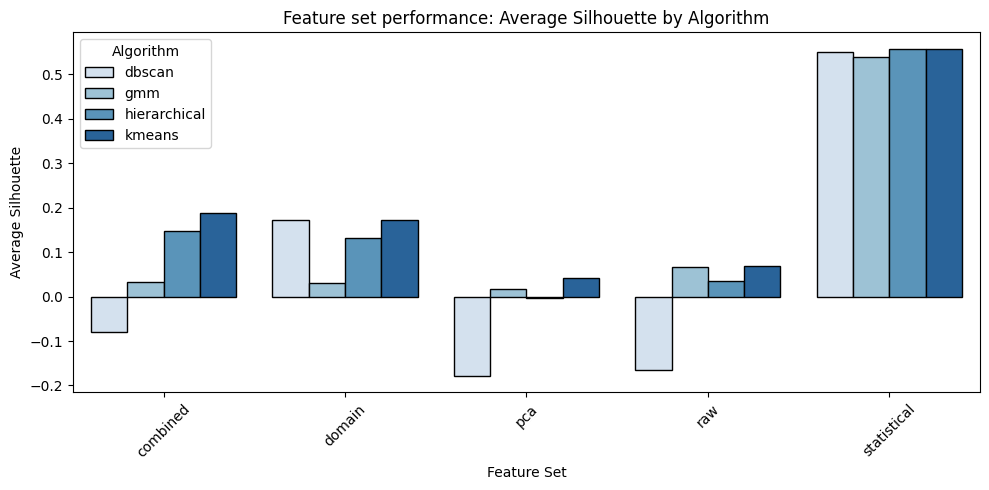

Top combinations (by silhouette):


,feature_set,algorithm,k,silhouette,k_str
19,statistical,hierarchical,6,0.558065,6
17,statistical,kmeans,6,0.558065,6
16,statistical,dbscan,dbscan,0.551747,dbscan
18,statistical,gmm,6,0.539017,6
13,combined,kmeans,6,0.188180,6
5,domain,kmeans,6,0.172569,6
4,domain,dbscan,dbscan,0.172327,dbscan
15,combined,hierarchical,6,0.146850,6
7,domain,hierarchical,6,0.132570,6
1,raw,kmeans,6,0.069597,6


In [46]:



agg = df.groupby(['feature_set', 'algorithm'])['silhouette'].agg(['mean','std','count']).reset_index()

# Build monochromatic palette
mono_palette = sns.color_palette("Blues", len(agg['algorithm'].unique()))

plt.figure(figsize=(10,5))
sns.barplot(
    data=agg, x='feature_set', y='mean', hue='algorithm',
    palette=mono_palette, edgecolor='black', ci=None
)
plt.title("Feature set performance: Average Silhouette by Algorithm")
plt.ylabel("Average Silhouette")
plt.xlabel("Feature Set")
plt.legend(title='Algorithm')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Show top-performing combos
top = df.sort_values('silhouette', ascending=False).head(12)
print("Top combinations (by silhouette):")
display(top)

